In [27]:
# importing fashion-mnist dataset from keras
from keras.datasets import fashion_mnist
#split data to test and train
(train_X,train_Y), (test_X,test_Y) = fashion_mnist.load_data()

In [28]:
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

print('Train shape and dimention: ', train_X.shape, train_Y.shape)
print('Test shape and dimnetion: ', test_X.shape, test_Y.shape)

Train shape and dimention:  (60000, 28, 28) (60000,)
Test shape and dimnetion:  (10000, 28, 28) (10000,)


In [29]:
classes = np.unique(train_Y)
nclasses = len(classes)
print('Num of outputs: ', nclasses)
print('Num of classes: ', classes)

Num of outputs:  10
Num of classes:  [0 1 2 3 4 5 6 7 8 9]


In [30]:
tr_x = train_X
ts_x = test_X
tr_y = train_Y
ts_y = test_Y

In [31]:
#converting to vector
train_X = train_X.reshape(-1, 28, 28, 1)
test_X = test_X.reshape(-1, 28, 28, 1)
train_X.shape, test_X.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [32]:
#normalize
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255
test_X = test_X / 255

In [33]:
#convert to one-hot vector
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

print('Main label: ', train_Y[0])
print('One-hot label: ', train_Y_one_hot[0])

Main label:  9
One-hot label:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [34]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_label, valid_label = train_test_split(train_X, train_Y_one_hot, test_size = 0.2, random_state = 13)

In [35]:
train_X.shape, valid_X.shape, train_label.shape, valid_label.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

In [36]:
import keras
from keras.models import Sequential, Input, Model 
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [37]:
batch_size = 64
epochs = 20
num_classes = 10

In [38]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import ( Conv2D ,MaxPooling2D,
                                     Dropout,Dense,Flatten)

from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner import HyperModel

import pandas as pd
import numpy as np
#compile for accuracy

def model_builder( hp):          #hp means hyper parameters
      fashion_model = Sequential()
      
      fashion_model.add(Conv2D(32, kernel_size = (3, 3), activation = 'linear', input_shape=(28,28,1), padding = 'same'))
      fashion_model.add(LeakyReLU(alpha = 0.1))
      fashion_model.add(MaxPooling2D((2,2), padding = 'same'))

      fashion_model.add(Conv2D(64, (3, 3), activation = 'linear', padding = 'same'))
      fashion_model.add(LeakyReLU(alpha = 0.1))
      fashion_model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))

      fashion_model.add(Conv2D(128, (3, 3), activation = 'linear', padding = 'same'))
      fashion_model.add(LeakyReLU(alpha = 0.1))                  
      fashion_model.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

      fashion_model.add(Flatten())

      hp_units = hp.Int('units', min_value=32, max_value=512, step=32)

      fashion_model.add(Dense(units=hp_units, activation = 'linear'))
      fashion_model.add(LeakyReLU(alpha = 0.1))                  
      fashion_model.add(Dense(num_classes, activation = 'softmax'))

      hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

      fashion_model.compile(loss = keras.losses.categorical_crossentropy, optimizer = Adam(), metrics = ['accuracy'])
      return fashion_model

In [40]:
import keras_tuner as kt
#Instantiate the tuner and perform hypertuning
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3
                     )


INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


In [41]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(train_X,train_Y_one_hot, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


Trial 30 Complete [00h 14m 22s]
val_accuracy: 0.10260416567325592

Best val_accuracy So Far: 0.1029166653752327
Total elapsed time: 02h 59m 33s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 192 and the optimal learning rate for the optimizer
is 0.001.



In [42]:
model = tuner.hypermodel.build(best_hps)
fashion_train = model.fit(train_X,train_Y_one_hot, epochs=20, validation_split=0.2)


Epoch 1/20
1200/1200 [==============================] - 105s 87ms/step - loss: 2.3033 - accuracy: 0.0989 - val_loss: 2.3027 - val_accuracy: 0.0984
Epoch 2/20
1200/1200 [==============================] - 85s 71ms/step - loss: 2.3036 - accuracy: 0.1004 - val_loss: 2.3029 - val_accuracy: 0.1003
Epoch 3/20
1200/1200 [==============================] - 88s 73ms/step - loss: 2.3031 - accuracy: 0.0992 - val_loss: 2.3028 - val_accuracy: 0.1019
Epoch 4/20
1200/1200 [==============================] - 88s 73ms/step - loss: 2.3033 - accuracy: 0.0982 - val_loss: 2.3027 - val_accuracy: 0.1015
Epoch 5/20
1200/1200 [==============================] - 88s 73ms/step - loss: 2.3031 - accuracy: 0.0984 - val_loss: 2.3027 - val_accuracy: 0.1001
Epoch 6/20
1200/1200 [==============================] - 86s 71ms/step - loss: 2.3035 - accuracy: 0.1001 - val_loss: 2.3029 - val_accuracy: 0.1011
Epoch 7/20
1200/1200 [==============================] - 87s 72ms/step - loss: 2.3031 - accuracy: 0.0983 - val_loss: 2.3030 

In [43]:
import keras_tuner as kt
#Instantiate the tuner and perform hypertuning
tuner1 = kt.RandomSearch(model_builder,
                     objective='val_accuracy',
                    )


INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [44]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner1.search(train_X,train_Y_one_hot, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner1.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 192 and the optimal learning rate for the optimizer
is 0.001.



In [45]:
model1 = tuner1.hypermodel.build(best_hps)
fashion_train1 = model.fit(train_X,train_Y_one_hot, epochs=20, validation_split=0.2)


Epoch 1/20
1200/1200 [==============================] - 85s 70ms/step - loss: 2.3034 - accuracy: 0.0993 - val_loss: 2.3036 - val_accuracy: 0.0978
Epoch 2/20
1200/1200 [==============================] - 86s 72ms/step - loss: 2.3032 - accuracy: 0.1003 - val_loss: 2.3030 - val_accuracy: 0.0966
Epoch 3/20
1200/1200 [==============================] - 86s 71ms/step - loss: 2.3031 - accuracy: 0.0996 - val_loss: 2.3026 - val_accuracy: 0.1021
Epoch 4/20
1200/1200 [==============================] - 85s 71ms/step - loss: 2.3034 - accuracy: 0.1013 - val_loss: 2.3031 - val_accuracy: 0.1003
Epoch 5/20
1200/1200 [==============================] - 87s 73ms/step - loss: 2.3033 - accuracy: 0.0986 - val_loss: 2.3028 - val_accuracy: 0.1027
Epoch 6/20
1200/1200 [==============================] - 92s 77ms/step - loss: 2.3030 - accuracy: 0.1003 - val_loss: 2.3028 - val_accuracy: 0.1004
Epoch 7/20
1200/1200 [==============================] - 92s 76ms/step - loss: 2.3033 - accuracy: 0.0994 - val_loss: 2.3029 -

In [46]:
#Hyperbrand tunning is applied to the model 

In [47]:
!pip install -q -U keras-tuner

In [48]:
import keras_tuner as kt
from keras_tuner import RandomSearch

In [52]:
#print accuarcy and loss for testset
test_eval = model.evaluate(test_X, test_Y_one_hot, verbose = 0)
print(' loss for test: ', test_eval[0])
print(' accuracy for test: ', test_eval[1])


 loss for test:  2.7403483390808105
 accuracy for test:  0.07779999822378159


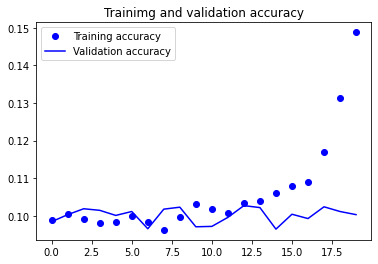

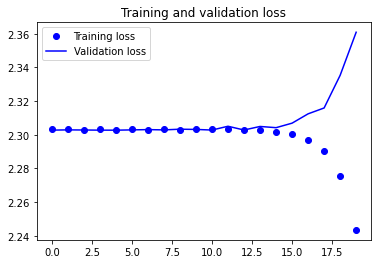

In [53]:
accuracy = fashion_train.history['accuracy']
val_accuracy = fashion_train.history['val_accuracy']
loss = fashion_train.history['loss']
val_loss = fashion_train.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation accuracy')
plt.title('Trainimg and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [54]:
#using dropout for 20 epochs to solve overfitting and remove noise
batch_size = 64
epochs = 20
num_classes = 10

In [55]:
#use max pooling and padding 
fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size = (3, 3), activation = 'linear', input_shape=(28,28,1), padding = 'same'))
fashion_model.add(LeakyReLU(alpha = 0.1))
fashion_model.add(MaxPooling2D((2,2), padding = 'same'))
fashion_model.add(Dropout(0.25))

fashion_model.add(Conv2D(64, (3, 3), activation = 'linear', padding = 'same'))
fashion_model.add(LeakyReLU(alpha = 0.1))
fashion_model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
fashion_model.add(Dropout(0.25))

fashion_model.add(Conv2D(128, (3, 3), activation = 'linear', padding = 'same'))
fashion_model.add(LeakyReLU(alpha = 0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))
fashion_model.add(Dropout(0.4))

fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation = 'linear'))
fashion_model.add(LeakyReLU(alpha = 0.1)) 
fashion_model.add(Dropout(0.3))
fashion_model.add(Dense(num_classes, activation = 'softmax'))


In [56]:
#summary of model
fashion_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                      

In [57]:
fashion_model.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.Adam(), metrics = ['accuracy'])

In [ ]:
fashion_train_dropout = fashion_model.fit(train_X, train_label, batch_size = batch_size, epochs = epochs, verbose = 1, validation_data = (valid_X, valid_label))

Epoch 1/20
750/750 [==============================] - 107s 142ms/step - loss: 0.5781 - accuracy: 0.7867 - val_loss: 0.3728 - val_accuracy: 0.8623
Epoch 2/20
750/750 [==============================] - ETA: 0s - loss: 0.3711 - accuracy: 0.8639

In [ ]:
fashion_model.save("fashion_model_dropout.h5py")

In [ ]:
test_eval = fashion_model.evaluate(test_X, test_Y_one_hot, verbose = 1)

In [ ]:
print('Test loss: ', test_eval[0])
print('Test accuracy: ', test_eval[1])

In [ ]:
accuracy = fashion_train_dropout.history['accuracy']
val_accuracy = fashion_train_dropout.history['val_accuracy']
loss = fashion_train_dropout.history['loss']
val_loss = fashion_train_dropout.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
predictes_classes = fashion_model.predict(test_X)
predicted_classes = np.argmax(np.round(predictes_classes), axis = 1)
predicted_classes.shape, test_Y.shape

In [ ]:
correct = np.where(predicted_classes == test_Y)[0]

print ("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_X[correct].reshape(28, 28), cmap = 'gray', interpolation = 'none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_Y[correct]))    
    plt.tight_layout()

In [ ]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print ("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_Y[incorrect]))
    plt.tight_layout()

In [ ]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))